## Description:
Run many models looking at:
1 - BMI and omic variables longitudinally 
2 - BMI and variable changes from BL-6m and 6m-12m

In [1]:
import pandas as pd
import os
import re
import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools 
import glob
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
import matplotlib as mpl
from merf.merf import MERF
from sklearn.model_selection import train_test_split, KFold
from merf.viz import plot_merf_training_stats
from joblib import dump
sns.set_context("poster")
mpl.rcParams['figure.figsize'] = (11,8)

current_dir = os.getcwd() # Get the current working directory
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))
sys.path.append(parent_dir)
from em_utils import *

# test and train set directories for input data
longitudinal_dir = "/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/merf_dfs/5.combined/"
delta_dir = "/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/zachs_rerun/drift_fs/csv/all_omic_processed_data/deltas/"
clin_dir = "/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/data/clinical/transformed/aim2/merf_ready"
# Where hyperparameter training results are
delta_df_dir = "/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/merf_dfs/6.two_timepoints_deltas"
long_df_dir = "/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/merf_dfs/5.combined"
func_df_dir = "/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/merf_dfs/3.functional"
taxa_long_df_dir = "/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/merf_dfs/2.taxa"
clinical_df_dir = "/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/merf_dfs/1.clinical"
micom_df_dir = "/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/merf_dfs/4.micom"

In [2]:
# test and train longitudinal files 
test_all = pd.read_csv(os.path.join(longitudinal_dir, 'test_merged_all_omics_raw_meta.csv'))  
train_all = pd.read_csv(os.path.join(longitudinal_dir, 'training_merged_all_omics_raw_meta.csv'))  
print("test long shape = ", test_all.shape)
print("train long shape = ", train_all.shape)
print("test longitudinal: ", test_all.columns)
print("train longitudinal: ", train_all.columns)

# test and train delta files 
test_delta = read_data(delta_dir, "jan30_all_delta_test_imp_varcheck.csv")
train_delta = read_data(delta_dir, "jan30_all_delta_train_imp_varcheck.csv")
print("test delta shape = ", test_delta.shape)
print("train delta shape = ", train_delta.shape)
print("test delta: ", test_delta.columns)
print("train delta: ", train_delta.columns)

# hyperparameter training files 
delta_df = pd.read_csv(os.path.join(delta_df_dir, 'jan30_2times_all_omic_deltas_BMI_remove_time_var_imputed_swapped.csv'))
long_df = pd.read_csv(os.path.join(long_df_dir, 'jan13_params_fine_tuning_results_all_omics.csv'))
func_df = pd.read_csv(os.path.join(func_df_dir, 'dec6_magggie_params_fine_tuning_results_raw_functional.csv'))
taxa_df = pd.read_csv(os.path.join(taxa_long_df_dir, 'dec6_maggie_params_tuning_raw_taxa_oob.csv'))
micom_df = pd.read_csv(os.path.join(micom_df_dir, 'dec6_maggie_params_fine_tuning_results_raw_micom.csv'))
meta_df = pd.read_csv(os.path.join(clinical_df_dir, 'dec5_maggie_params_tuning_raw_clinical_oob.csv'))
#meta_df = pd.read_csv('/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/merf_dfs/1.clinical/fine_tuning_results_raw_clinical.csv')

test long shape =  (66, 635)
train long shape =  (268, 635)
test longitudinal:  Index(['Unnamed: 0_test_long', 'record_id', 'subject_id', 'randomized_group',
       'cohort_number', 'sex', 'race', 'age', 'time', 'Glucose',
       ...
       'outcome_BMI_fnl_merged_data', 'Unnamed: 0_merged_data', 'bmi_prs',
       'old_or_new', 'predicted_BL_BMI', 'differences_BL_BMI',
       'diff_BMI_quartile', 'diff_BMI_std', 'methyl_bmi_rs',
       'methyl_bmi_rs_standardized'],
      dtype='object', length=635)
train longitudinal:  Index(['Unnamed: 0_train_long', 'record_id', 'subject_id', 'randomized_group',
       'cohort_number', 'sex', 'race', 'age', 'time', 'Glucose',
       ...
       'outcome_BMI_fnl_merged_data', 'Unnamed: 0_merged_data', 'bmi_prs',
       'old_or_new', 'predicted_BL_BMI', 'differences_BL_BMI',
       'diff_BMI_quartile', 'diff_BMI_std', 'methyl_bmi_rs',
       'methyl_bmi_rs_standardized'],
      dtype='object', length=635)
test delta shape =  (62, 920)
train delta shape 

### Longitudinal BMI first 

In [3]:
# Drop some columns 
train_long = train_all.drop(['Unnamed: 0_y','Unnamed: 0_x', 'Unnamed: 0_train_long', 'Unnamed: 0_merged_data',
                    'sample_id','subject_id', 'all_samples_x', 'all_samples_y', 'record_id','SampleID',
                    'time_x', 'time_y', 'x_t', 't', 'time', 'outcome_BMI_fnl_x', 'outcome_BMI_fnl_y', 
                    'outcome_BMI_fnl_merged_data', 'old_or_new', 'predicted_BL_BMI', 
                    'differences_BL_BMI', 'diff_BMI_quartile', 'diff_BMI_std', 'methyl_bmi_rs', 'methyl_bmi_rs_standardized'], 
                    axis=1)

test_long = test_all.drop(['Unnamed: 0_y','Unnamed: 0_x', 'Unnamed: 0_test_long', 'Unnamed: 0_merged_data',
                    'sample_id','subject_id', 'all_samples_x', 'all_samples_y', 'record_id', 'SampleID',
                    'time_x', 'time_y', 'x_t', 't', 'time', 'outcome_BMI_fnl_x', 'outcome_BMI_fnl_y', 
                    'outcome_BMI_fnl_merged_data', 'old_or_new', 'predicted_BL_BMI', 
                    'differences_BL_BMI', 'diff_BMI_quartile', 'diff_BMI_std', 'methyl_bmi_rs', 'methyl_bmi_rs_standardized'], 
                    axis=1)
print("test long shape = ", test_long.shape)
print("train long shape = ", train_long.shape)

test_long.rename(columns={'outcome_BMI_fnl_test_long': 'outcome_bmi_fnl'}, inplace=True)
train_long.rename(columns={'outcome_BMI_fnl_train_long': 'outcome_bmi_fnl'}, inplace=True)

print("test longitudinal: ", list(test_long.columns))
print("train longitudinal: ", list(train_long.columns))

test long shape =  (66, 610)
train long shape =  (268, 610)
test longitudinal:  ['randomized_group', 'cohort_number', 'sex', 'race', 'age', 'Glucose', 'HDL_Total_Direct_lipid', 'HOMA_IR', 'Insulin_endo', 'LDL_Calculated', 'Triglyceride_lipid', 'outcome_bmi_fnl', 'proton', 'Diacetyl', 'Butyrate', 'Formate', 'acetone', 'X2.methylbutyrate', 'Valeric.Acid', 'Methane', 'X1.4.Dihydroxy.2.naphthoate', 'X2.Oxoglutarate', 'Pyruvate', 'D.lactate', 'L.lactate', 'laurate', 'Phenol', 'L.Carnitine', 'Isopropanol', 'p.Cresol', 'O2', 'X1.Propanol', 'butanol', 'Propanal', 'X4.hydroxyphenylacetate', 'X.S..propane.1.2.diol', 'Propane.1.3.diol', 'R_R__2_3_Butanediol', 'Oxaloacetate', 'sulfate', 'octadecenoate..n.C18.1.', 'o.Succinylbenzoate', 'Thymidine', 'Reduced.riboflavin', 'Riboflavin', 'X2.Hydroxyphenylacetate', 'Sulfite', 'thiosulfate.2..', 'X.3.4.dihydroxyphenyl.acetate', 'Diphosphate', 'trimethylamine', 'glycine.betaine', 'Choline', 'Trimethylamine.N.oxide', 'Isochorismate', 'Inosine', 'xanthosine

In [4]:
# Find the column numbers for "proton" and "Carbon.dioxide" in train_set
proton_column = train_long.columns.get_loc("proton")
carbon_dioxide_column = train_long.columns.get_loc("Carbon.dioxide")
proton_column_test = test_long.columns.get_loc("proton")
carbon_dioxide_column_test = test_long.columns.get_loc("Carbon.dioxide")

# Columns to KEEP for only meta 
meta_keep = ['all_samples','outcome_bmi_fnl', 'randomized_group', 'cohort_number', 'sex', 'race', 'age', 'Glucose', 'HDL_Total_Direct_lipid', 'HOMA_IR', 'Insulin_endo', 'LDL_Calculated', 'Triglyceride_lipid']
only_grs = ['all_samples','outcome_bmi_fnl', 'bmi_prs']
only_taxa = ['all_samples','outcome_bmi_fnl'] + [col for col in train_long.columns if col.startswith("g__")]
only_micom = ['all_samples','outcome_bmi_fnl'] + [col for col in train_long.columns if col in train_long.columns[proton_column:carbon_dioxide_column+1]]
# Create a set of all columns to exclude
exclude_columns = set(meta_keep + only_grs + only_taxa + only_micom)
only_pathway = ['all_samples', 'outcome_bmi_fnl'] + [col for col in train_long.columns if col not in exclude_columns]

# Columns to KEEP for only meta + GRS
meta_grs = ['all_samples','outcome_bmi_fnl', 'randomized_group', 'cohort_number', 'sex', 'race', 'age', 'Glucose', 'HDL_Total_Direct_lipid', 'HOMA_IR', 'Insulin_endo', 'LDL_Calculated', 'Triglyceride_lipid', 'bmi_prs']
# Columns to KEEP for only meta + GRS + taxa
meta_grs_taxa = meta_grs + [col for col in train_long.columns if col.startswith("g__")]
meta_grs_taxa_test = meta_grs + [col for col in test_long.columns if col.startswith("g__")]
# Columns to KEEP for only meta + GRS + taxa + pathway/functional 
meta_grs_taxa_functional = meta_grs_taxa + [col for col in train_long.columns if col not in train_long.columns[proton_column:carbon_dioxide_column+1]]
meta_grs_taxa_functional_test = meta_grs_taxa + [col for col in test_long.columns if col not in test_long.columns[proton_column_test:carbon_dioxide_column_test+1]]
# Columns to DROP for only GRS + taxa + pathway/functional + micom (no meta)
all_but_meta = ['randomized_group', 'cohort_number', 'sex', 'race', 'age', 'Glucose', 'HDL_Total_Direct_lipid', 'HOMA_IR', 'Insulin_endo', 'LDL_Calculated', 'Triglyceride_lipid']

## 1.1 Trying Meta from omic DF

PTEV is the best one 
First 5 columns for the lowest mean_ptev_score:
n_estimators         500.00
max_depth               NaN
min_samples_split      0.05
max_iter               2.00
n_splits              10.00
Name: 20, dtype: float64

---------- Select predictors for training set ----------
---------- Select predictors for test set ----------
---------- Run MERF models ----------
First 5 columns for the lowest mean_mse_score:
n_estimators         500.00
max_depth               NaN
min_samples_split      0.15
max_iter               2.00
n_splits               5.00
Name: 31, dtype: float64
First 5 columns for the lowest mean_prev_score:
n_estimators         500.00
max_depth               NaN
min_samples_split      0.15
max_iter               2.00
n_splits               5.00
Name: 31, dtype: float64
First 5 columns for the lowest mean_ptev_score:
n_estimators         100.00
max_depth               NaN
min_samples_split      0.05
max_iter               2.00
n_splits              10.00
Name: 2, dtype: float64

First 5 columns for the highest oob_score:
n_estimators         1000.00
max_depth                NaN
min_samples_split       0.05
max_iter               10.00
n_splits               10.00
Name: 41, dtype: float64
-

INFO     [merf.py:307] Training GLL is 778.5854005107182 at iteration 1.
INFO     [merf.py:307] Training GLL is 755.9815499616367 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/em_utils.py:772: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, new_row], ignore_index=True)


---------- RUN Prev Model WITH TUNING PARAMETERS 🌱 ----------


INFO     [merf.py:307] Training GLL is 773.6399514693811 at iteration 1.
INFO     [merf.py:307] Training GLL is 752.6612959697192 at iteration 2.


---------- RUN PTEV Model WITH TUNING PARAMETERS 🌱 ----------


INFO     [merf.py:307] Training GLL is 634.1809610886928 at iteration 1.
INFO     [merf.py:307] Training GLL is 639.0292360189027 at iteration 2.


---------- RUN OOB Model WITH TUNING PARAMETERS 🌱 ----------


INFO     [merf.py:307] Training GLL is 614.8961399269538 at iteration 1.
INFO     [merf.py:307] Training GLL is 629.4270737985249 at iteration 2.
INFO     [merf.py:307] Training GLL is 608.7982622145073 at iteration 3.
INFO     [merf.py:307] Training GLL is 593.1567831976594 at iteration 4.
INFO     [merf.py:307] Training GLL is 579.2879790677082 at iteration 5.
INFO     [merf.py:307] Training GLL is 567.9572716412372 at iteration 6.
INFO     [merf.py:307] Training GLL is 562.4367701963433 at iteration 7.
INFO     [merf.py:307] Training GLL is 558.9365161073098 at iteration 8.
INFO     [merf.py:307] Training GLL is 557.3328714831542 at iteration 9.
INFO     [merf.py:307] Training GLL is 556.774559396356 at iteration 10.


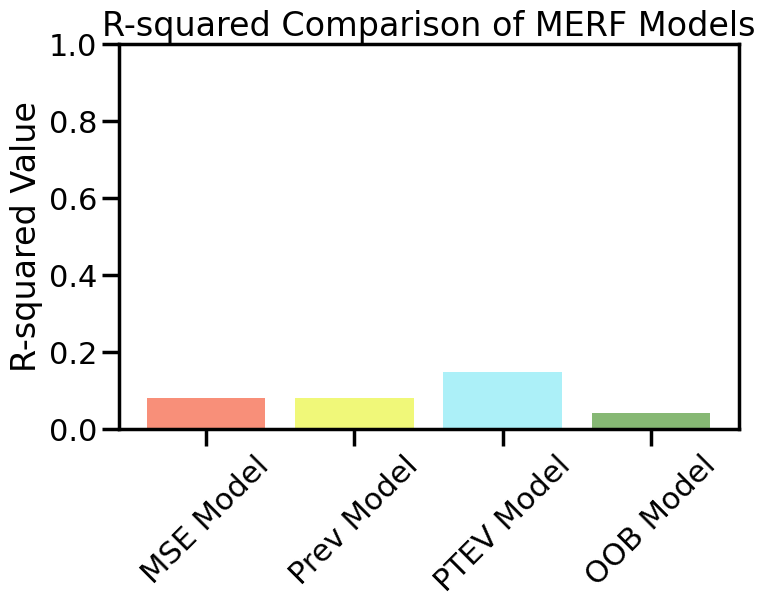

Best model: PTEV Model with R-squared: 0.1472
R-squared values: {'MSE Model': 0.07930831236852276, 'Prev Model': 0.08113815571825345, 'PTEV Model': 0.1471904192703386, 'OOB Model': 0.04201591803904714}
Results DataFrame:
          Model  y_hat_new  R_squared  \
0    MSE Model  29.341945   0.079308   
1    MSE Model  33.658500   0.079308   
2    MSE Model  30.332570   0.079308   
3    MSE Model  28.700100   0.079308   
4    MSE Model  30.694475   0.079308   
..         ...        ...        ...   
259  OOB Model  29.631307   0.042016   
260  OOB Model  29.711125   0.042016   
261  OOB Model  33.538054   0.042016   
262  OOB Model  33.819345   0.042016   
263  OOB Model  32.503103   0.042016   

                            Top_15_Feature_Importances Cluster  
0    [{'Feature': 'HOMA_IR', 'Importance': 0.634164...       4  
1    [{'Feature': 'HOMA_IR', 'Importance': 0.634164...       4  
2    [{'Feature': 'HOMA_IR', 'Importance': 0.634164...       5  
3    [{'Feature': 'HOMA_IR', 'Importa

In [5]:
train_l = train_long[meta_keep]
test_l = test_long[meta_keep]
output_dir = "/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/for_score_long"
r2_out = 'r2_only_meta_merf_bmi_long_feb10_all.png'
feature_imp_out = 'fi_only_meta_merf_bmi_long_feb10_all.png'
results_filename = 'merf_results_long_only_meta.csv'

print("---------- Select predictors for training set ----------")
train_set = train_l
X = train_set.drop(['outcome_bmi_fnl', 'all_samples'], axis=1)
Y = train_set['outcome_bmi_fnl'].to_numpy()
clusters_train = train_set['all_samples'].to_numpy() 
Z = np.ones((train_set.shape[0], 1)) 

print("---------- Select predictors for test set ----------")
test_set = test_l
X_new = test_set.drop(['outcome_bmi_fnl', 'all_samples'], axis=1)[X.columns].astype(X.dtypes)
Y_new = test_set['outcome_bmi_fnl'].to_numpy()  
clusters_new = pd.Series(test_set['all_samples'])  
Z_new = np.ones((len(X_new), 1))

print("---------- Run MERF models ----------")
#r2_run1, fi_run1 = run_merf_analysis2(X, Y, Z, clusters_train,
#                             X_new, Y_new, Z_new, clusters_new, 
#                             long_df, output_dir, r2_out, feature_imp_out)

r2_values, results_df = run_merf_analysis2(
    X, Y, Z, clusters_train,
    X_new, Y_new, Z_new, clusters_new,
    long_df,
    output_dir, r2_out, feature_imp_out, results_filename
)

# Print the R-squared values and the results DataFrame
print("R-squared values:", r2_values)
print("Results DataFrame:\n", results_df)

#print("---------- Run best MERF 🧮 ----------")# Define the parameter grid list
# param_grid_list = [
#     {'n_estimators': 500, 'max_depth': None, 
#      'min_samples_split': 0.05, 'max_iter': 2}
# ]
# # Call the run_merf function with the required parameters
# only_meta = run_merf(X, Y, Z, clusters_train,
#                      X_new, Y_new, Z_new, clusters_new, 
#                      param_grid_list, results_name="only_meta_results")
# # View the "only_meta" output
# print("Viewing the 'only_meta' output:")
# for result in only_meta:
#     print(f"Model Parameters: {result['params']}")
#     print(f"R-squared: {result['r2']:.4f}")
#     print("Feature Importances:")
#     for feature, importance in zip(X.columns, result['feature_importances']):
#         print(f"{feature}: {importance:.4f}")
#     print("\n")
# # End of Selection


## Only PRS

---------- Select predictors for training set ----------
---------- Select predictors for test set ----------
---------- Run MERF models ----------
First 5 columns for the lowest mean_mse_score:
n_estimators         500.00
max_depth               NaN
min_samples_split      0.15
max_iter               2.00
n_splits               5.00
Name: 31, dtype: float64
First 5 columns for the lowest mean_prev_score:
n_estimators         500.00
max_depth               NaN
min_samples_split      0.15
max_iter               2.00
n_splits               5.00
Name: 31, dtype: float64
First 5 columns for the lowest mean_ptev_score:
n_estimators         100.00
max_depth               NaN
min_samples_split      0.05
max_iter               2.00
n_splits              10.00
Name: 2, dtype: float64

First 5 columns for the highest oob_score:
n_estimators         1000.00
max_depth                NaN
min_samples_split       0.05
max_iter               10.00
n_splits               10.00
Name: 41, dtype: float64
-

INFO     [merf.py:307] Training GLL is 858.284039930802 at iteration 1.
INFO     [merf.py:307] Training GLL is 882.1049149944735 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/em_utils.py:772: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, new_row], ignore_index=True)


---------- RUN Prev Model WITH TUNING PARAMETERS 🌱 ----------


INFO     [merf.py:307] Training GLL is 858.1915628097471 at iteration 1.
INFO     [merf.py:307] Training GLL is 881.372710998105 at iteration 2.
INFO     [merf.py:307] Training GLL is 775.9842772485423 at iteration 1.


---------- RUN PTEV Model WITH TUNING PARAMETERS 🌱 ----------


INFO     [merf.py:307] Training GLL is 832.5590484996104 at iteration 2.


---------- RUN OOB Model WITH TUNING PARAMETERS 🌱 ----------


INFO     [merf.py:307] Training GLL is 777.7114163696712 at iteration 1.
INFO     [merf.py:307] Training GLL is 835.8743844680303 at iteration 2.
INFO     [merf.py:307] Training GLL is 847.1082724558606 at iteration 3.
INFO     [merf.py:307] Training GLL is 853.3634832190286 at iteration 4.
INFO     [merf.py:307] Training GLL is 857.6320229082806 at iteration 5.
INFO     [merf.py:307] Training GLL is 860.4695881286418 at iteration 6.
INFO     [merf.py:307] Training GLL is 862.6513647071372 at iteration 7.
INFO     [merf.py:307] Training GLL is 864.6573887037545 at iteration 8.
INFO     [merf.py:307] Training GLL is 866.0148418132843 at iteration 9.
INFO     [merf.py:307] Training GLL is 867.6274751452534 at iteration 10.


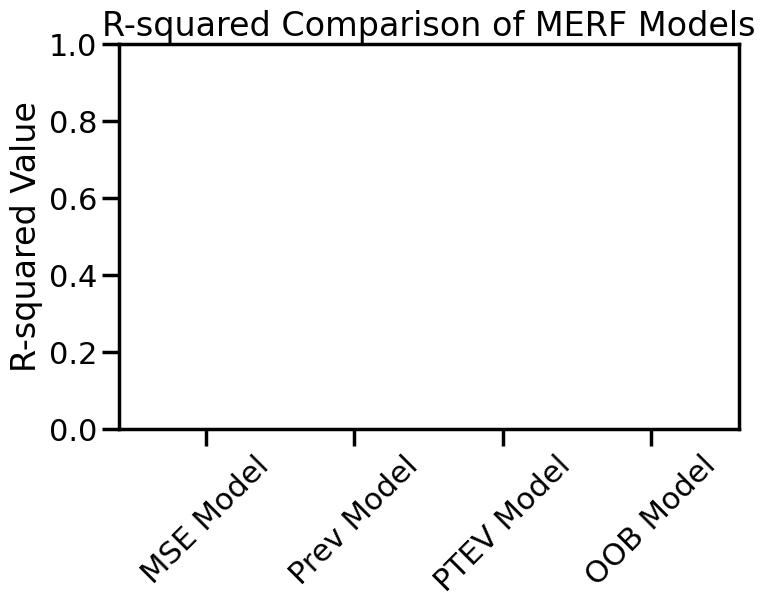

Best model: MSE Model with R-squared: -0.4743
R-squared values: {'MSE Model': -0.4743485657188151, 'Prev Model': -0.4796085310725766, 'PTEV Model': -0.7455209795955515, 'OOB Model': -0.6457970861992772}
Results DataFrame:
          Model  y_hat_new  R_squared  \
0    MSE Model  32.463641  -0.474349   
1    MSE Model  32.463641  -0.474349   
2    MSE Model  31.431478  -0.474349   
3    MSE Model  31.431478  -0.474349   
4    MSE Model  31.431478  -0.474349   
..         ...        ...        ...   
259  OOB Model  32.487114  -0.645797   
260  OOB Model  32.487114  -0.645797   
261  OOB Model  30.424807  -0.645797   
262  OOB Model  30.424807  -0.645797   
263  OOB Model  30.424807  -0.645797   

                      Top_15_Feature_Importances Cluster  
0    [{'Feature': 'bmi_prs', 'Importance': 1.0}]       4  
1    [{'Feature': 'bmi_prs', 'Importance': 1.0}]       4  
2    [{'Feature': 'bmi_prs', 'Importance': 1.0}]       5  
3    [{'Feature': 'bmi_prs', 'Importance': 1.0}]       5  
4

In [6]:
train_l = train_long[only_grs]
test_l = test_long[only_grs]
output_dir = "/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/for_score_long"
r2_out = 'r2_only_grs_merf_bmi_long_feb10_all.png'
feature_imp_out = 'fi_only_grs_merf_bmi_long_feb10_all.png'
results_filename = 'merf_results_long_meta_grs.csv'

print("---------- Select predictors for training set ----------")
train_set = train_l
X = train_set.drop(['outcome_bmi_fnl', 'all_samples'], axis=1)
Y = train_set['outcome_bmi_fnl'].to_numpy()
clusters_train = train_set['all_samples'].to_numpy() 
Z = np.ones((train_set.shape[0], 1)) 

print("---------- Select predictors for test set ----------")
test_set = test_l
X_new = test_set.drop(['outcome_bmi_fnl', 'all_samples'], axis=1)[X.columns].astype(X.dtypes)
Y_new = test_set['outcome_bmi_fnl'].to_numpy()  
clusters_new = pd.Series(test_set['all_samples'])  
Z_new = np.ones((len(X_new), 1))

print("---------- Run MERF models ----------")
#r2_run2, fi_run2 = run_merf_analysis2(X, Y, Z, clusters_train,
#                             X_new, Y_new, Z_new, clusters_new, 
#                             long_df, output_dir, r2_out, feature_imp_out)
# Call the function
r2_values, results_df = run_merf_analysis2(
    X, Y, Z, clusters_train,
    X_new, Y_new, Z_new, clusters_new,
    long_df,
    output_dir, r2_out, feature_imp_out, results_filename
)

# Print the R-squared values and the results DataFrame
print("R-squared values:", r2_values)
print("Results DataFrame:\n", results_df)

## Only Taxa

---------- Select predictors for training set ----------
---------- Select predictors for test set ----------
---------- Run MERF models ----------
First 5 columns for the lowest mean_mse_score:
n_estimators         500.00
max_depth               NaN
min_samples_split      0.15
max_iter               2.00
n_splits               5.00
Name: 31, dtype: float64
First 5 columns for the lowest mean_prev_score:
n_estimators         500.00
max_depth               NaN
min_samples_split      0.15
max_iter               2.00
n_splits               5.00
Name: 31, dtype: float64
First 5 columns for the lowest mean_ptev_score:
n_estimators         100.00
max_depth               NaN
min_samples_split      0.05
max_iter               2.00
n_splits              10.00
Name: 2, dtype: float64

First 5 columns for the highest oob_score:
n_estimators         1000.00
max_depth                NaN
min_samples_split       0.05
max_iter               10.00
n_splits               10.00
Name: 41, dtype: float64
-

INFO     [merf.py:307] Training GLL is 711.4738640690922 at iteration 1.
INFO     [merf.py:307] Training GLL is 735.9001663265224 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/em_utils.py:772: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, new_row], ignore_index=True)


---------- RUN Prev Model WITH TUNING PARAMETERS 🌱 ----------


INFO     [merf.py:307] Training GLL is 716.2725609991062 at iteration 1.
INFO     [merf.py:307] Training GLL is 743.758742899991 at iteration 2.


---------- RUN PTEV Model WITH TUNING PARAMETERS 🌱 ----------


INFO     [merf.py:307] Training GLL is 484.37962477203297 at iteration 1.
INFO     [merf.py:307] Training GLL is 549.8667806640813 at iteration 2.


---------- RUN OOB Model WITH TUNING PARAMETERS 🌱 ----------


INFO     [merf.py:307] Training GLL is 464.8909093777599 at iteration 1.
INFO     [merf.py:307] Training GLL is 540.7917321906417 at iteration 2.
INFO     [merf.py:307] Training GLL is 540.461169204089 at iteration 3.
INFO     [merf.py:307] Training GLL is 540.4905669267803 at iteration 4.
INFO     [merf.py:307] Training GLL is 537.6999341985866 at iteration 5.
INFO     [merf.py:307] Training GLL is 529.9431830616834 at iteration 6.
INFO     [merf.py:307] Training GLL is 524.8356142949337 at iteration 7.
INFO     [merf.py:307] Training GLL is 521.6677738787206 at iteration 8.
INFO     [merf.py:307] Training GLL is 519.3389838986825 at iteration 9.
INFO     [merf.py:307] Training GLL is 517.5763120138239 at iteration 10.


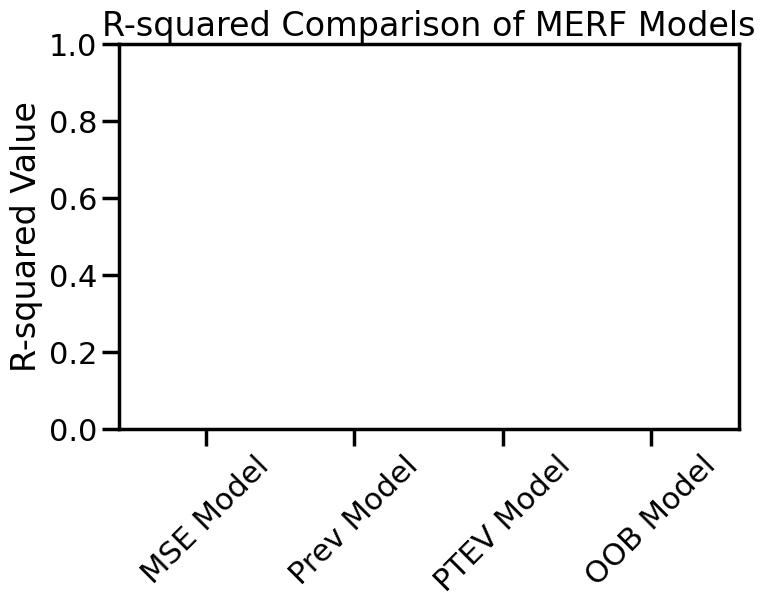

Best model: OOB Model with R-squared: -0.0226
R-squared values: {'MSE Model': -0.11343482092378054, 'Prev Model': -0.1266283895081779, 'PTEV Model': -0.16598756989891328, 'OOB Model': -0.02259793078752037}
Results DataFrame:
          Model  y_hat_new  R_squared  \
0    MSE Model  31.803823  -0.113435   
1    MSE Model  31.494317  -0.113435   
2    MSE Model  31.880041  -0.113435   
3    MSE Model  31.466940  -0.113435   
4    MSE Model  31.245889  -0.113435   
..         ...        ...        ...   
259  OOB Model  31.959291  -0.022598   
260  OOB Model  31.631959  -0.022598   
261  OOB Model  32.284992  -0.022598   
262  OOB Model  31.841609  -0.022598   
263  OOB Model  31.770534  -0.022598   

                            Top_15_Feature_Importances Cluster  
0    [{'Feature': 'g__UBA1417', 'Importance': 0.276...       4  
1    [{'Feature': 'g__UBA1417', 'Importance': 0.276...       4  
2    [{'Feature': 'g__UBA1417', 'Importance': 0.276...       5  
3    [{'Feature': 'g__UBA1417', '

In [7]:
train_l = train_long[only_taxa]
test_l = test_long[only_taxa]
output_dir = "/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/for_score_long"
r2_out = 'r2_only_taxa_merf_bmi_long_feb10.png'
feature_imp_out = 'fi_only_taxa_merf_bmi_long_feb10.png'
results_filename = 'merf_results_long_only_taxa.csv'

print("---------- Select predictors for training set ----------")
train_set = train_l
X = train_set.drop(['outcome_bmi_fnl', 'all_samples'], axis=1)
Y = train_set['outcome_bmi_fnl'].to_numpy()
clusters_train = train_set['all_samples'].to_numpy() 
Z = np.ones((train_set.shape[0], 1)) 

print("---------- Select predictors for test set ----------")
test_set = test_l
X_new = test_set.drop(['outcome_bmi_fnl', 'all_samples'], axis=1)[X.columns].astype(X.dtypes)
Y_new = test_set['outcome_bmi_fnl'].to_numpy()  
clusters_new = pd.Series(test_set['all_samples'])  
Z_new = np.ones((len(X_new), 1))

print("---------- Run MERF models ----------")
#r2_run2, fi_run2 = run_merf_analysis2(X, Y, Z, clusters_train,
#                             X_new, Y_new, Z_new, clusters_new, 
#                             long_df, output_dir, r2_out, feature_imp_out)
# Call the function
r2_values, results_df = run_merf_analysis2(
    X, Y, Z, clusters_train,
    X_new, Y_new, Z_new, clusters_new,
    long_df,
    output_dir, r2_out, feature_imp_out, results_filename
)

# Print the R-squared values and the results DataFrame
print("R-squared values:", r2_values)
print("Results DataFrame:\n", results_df)

## Only Micom

---------- Select predictors for training set ----------
---------- Select predictors for test set ----------
---------- Run MERF models ----------
First 5 columns for the lowest mean_mse_score:
n_estimators         500.00
max_depth               NaN
min_samples_split      0.15
max_iter               2.00
n_splits               5.00
Name: 31, dtype: float64
First 5 columns for the lowest mean_prev_score:
n_estimators         500.00
max_depth               NaN
min_samples_split      0.15
max_iter               2.00
n_splits               5.00
Name: 31, dtype: float64
First 5 columns for the lowest mean_ptev_score:
n_estimators         100.00
max_depth               NaN
min_samples_split      0.05
max_iter               2.00
n_splits              10.00
Name: 2, dtype: float64

First 5 columns for the highest oob_score:
n_estimators         1000.00
max_depth                NaN
min_samples_split       0.05
max_iter               10.00
n_splits               10.00
Name: 41, dtype: float64
-

INFO     [merf.py:307] Training GLL is 788.9443155060945 at iteration 1.
INFO     [merf.py:307] Training GLL is 804.2792954151331 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/em_utils.py:772: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, new_row], ignore_index=True)


---------- RUN Prev Model WITH TUNING PARAMETERS 🌱 ----------


INFO     [merf.py:307] Training GLL is 784.532530235507 at iteration 1.
INFO     [merf.py:307] Training GLL is 804.9632225041402 at iteration 2.


---------- RUN PTEV Model WITH TUNING PARAMETERS 🌱 ----------


INFO     [merf.py:307] Training GLL is 593.6248400787836 at iteration 1.
INFO     [merf.py:307] Training GLL is 640.8603572114555 at iteration 2.


---------- RUN OOB Model WITH TUNING PARAMETERS 🌱 ----------


INFO     [merf.py:307] Training GLL is 562.4828333043616 at iteration 1.
INFO     [merf.py:307] Training GLL is 622.193969378277 at iteration 2.
INFO     [merf.py:307] Training GLL is 616.9016761440508 at iteration 3.
INFO     [merf.py:307] Training GLL is 608.4088787796022 at iteration 4.
INFO     [merf.py:307] Training GLL is 602.3622215499048 at iteration 5.
INFO     [merf.py:307] Training GLL is 593.7279999735612 at iteration 6.
INFO     [merf.py:307] Training GLL is 590.1906280114068 at iteration 7.
INFO     [merf.py:307] Training GLL is 585.6133022173335 at iteration 8.
INFO     [merf.py:307] Training GLL is 579.9429314441701 at iteration 9.
INFO     [merf.py:307] Training GLL is 577.3406832051593 at iteration 10.


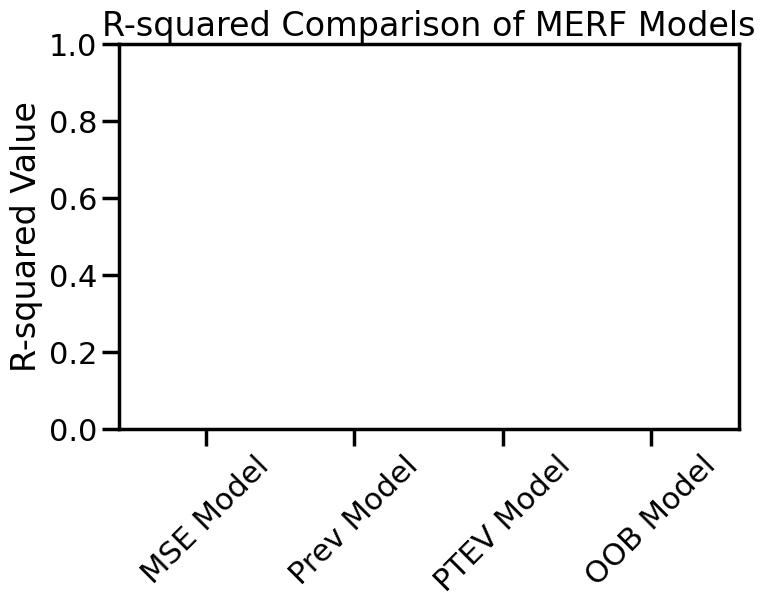

Best model: OOB Model with R-squared: -0.0772
R-squared values: {'MSE Model': -0.1720462802622449, 'Prev Model': -0.16217647892729792, 'PTEV Model': -0.21396689806379965, 'OOB Model': -0.07717163962354712}
Results DataFrame:
          Model  y_hat_new  R_squared  \
0    MSE Model  31.273596  -0.172046   
1    MSE Model  30.481424  -0.172046   
2    MSE Model  31.742576  -0.172046   
3    MSE Model  33.814358  -0.172046   
4    MSE Model  33.222025  -0.172046   
..         ...        ...        ...   
259  OOB Model  32.296992  -0.077172   
260  OOB Model  32.768651  -0.077172   
261  OOB Model  31.469190  -0.077172   
262  OOB Model  31.747793  -0.077172   
263  OOB Model  32.726585  -0.077172   

                            Top_15_Feature_Importances Cluster  
0    [{'Feature': 'Isochorismate', 'Importance': 0....       4  
1    [{'Feature': 'Isochorismate', 'Importance': 0....       4  
2    [{'Feature': 'Isochorismate', 'Importance': 0....       5  
3    [{'Feature': 'Isochorismate'

In [8]:
train_l = train_long[only_micom]
test_l = test_long[only_micom]
output_dir = "/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/for_score_long"
r2_out = 'r2_only_micom_merf_bmi_long_feb10.png'
feature_imp_out = 'fi_only_micom_merf_bmi_long_feb10.png'
results_filename = 'merf_results_long_only_micom.csv'

print("---------- Select predictors for training set ----------")
train_set = train_l
X = train_set.drop(['outcome_bmi_fnl', 'all_samples'], axis=1)
Y = train_set['outcome_bmi_fnl'].to_numpy()
clusters_train = train_set['all_samples'].to_numpy() 
Z = np.ones((train_set.shape[0], 1)) 

print("---------- Select predictors for test set ----------")
test_set = test_l
X_new = test_set.drop(['outcome_bmi_fnl', 'all_samples'], axis=1)[X.columns].astype(X.dtypes)
Y_new = test_set['outcome_bmi_fnl'].to_numpy()  
clusters_new = pd.Series(test_set['all_samples'])  
Z_new = np.ones((len(X_new), 1))

print("---------- Run MERF models ----------")
#r2_run2, fi_run2 = run_merf_analysis2(X, Y, Z, clusters_train,
#                             X_new, Y_new, Z_new, clusters_new, 
#                             long_df, output_dir, r2_out, feature_imp_out)
# Call the function
r2_values, results_df = run_merf_analysis2(
    X, Y, Z, clusters_train,
    X_new, Y_new, Z_new, clusters_new,
    long_df,
    output_dir, r2_out, feature_imp_out, results_filename
)

# Print the R-squared values and the results DataFrame
print("R-squared values:", r2_values)
print("Results DataFrame:\n", results_df)

## Only pathway data

---------- Select predictors for training set ----------
---------- Select predictors for test set ----------
---------- Run MERF models ----------
First 5 columns for the lowest mean_mse_score:
n_estimators         500.00
max_depth               NaN
min_samples_split      0.15
max_iter               2.00
n_splits               5.00
Name: 31, dtype: float64
First 5 columns for the lowest mean_prev_score:
n_estimators         500.00
max_depth               NaN
min_samples_split      0.15
max_iter               2.00
n_splits               5.00
Name: 31, dtype: float64
First 5 columns for the lowest mean_ptev_score:
n_estimators         100.00
max_depth               NaN
min_samples_split      0.05
max_iter               2.00
n_splits              10.00
Name: 2, dtype: float64

First 5 columns for the highest oob_score:
n_estimators         1000.00
max_depth                NaN
min_samples_split       0.05
max_iter               10.00
n_splits               10.00
Name: 41, dtype: float64
-

INFO     [merf.py:307] Training GLL is 716.2171727273212 at iteration 1.
INFO     [merf.py:307] Training GLL is 734.2215288086988 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/em_utils.py:772: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, new_row], ignore_index=True)


---------- RUN Prev Model WITH TUNING PARAMETERS 🌱 ----------


INFO     [merf.py:307] Training GLL is 720.4714422920489 at iteration 1.
INFO     [merf.py:307] Training GLL is 735.6032686251999 at iteration 2.


---------- RUN PTEV Model WITH TUNING PARAMETERS 🌱 ----------


INFO     [merf.py:307] Training GLL is 452.1671193698482 at iteration 1.
INFO     [merf.py:307] Training GLL is 534.211897089606 at iteration 2.


---------- RUN OOB Model WITH TUNING PARAMETERS 🌱 ----------


INFO     [merf.py:307] Training GLL is 469.7818426183563 at iteration 1.
INFO     [merf.py:307] Training GLL is 527.3390393524294 at iteration 2.
INFO     [merf.py:307] Training GLL is 525.0758541489884 at iteration 3.
INFO     [merf.py:307] Training GLL is 522.1687392868605 at iteration 4.
INFO     [merf.py:307] Training GLL is 520.0722322859297 at iteration 5.
INFO     [merf.py:307] Training GLL is 520.0566228954519 at iteration 6.
INFO     [merf.py:307] Training GLL is 518.6750064952364 at iteration 7.
INFO     [merf.py:307] Training GLL is 512.3799373842359 at iteration 8.
INFO     [merf.py:307] Training GLL is 513.3229701434803 at iteration 9.
INFO     [merf.py:307] Training GLL is 507.63637457203095 at iteration 10.


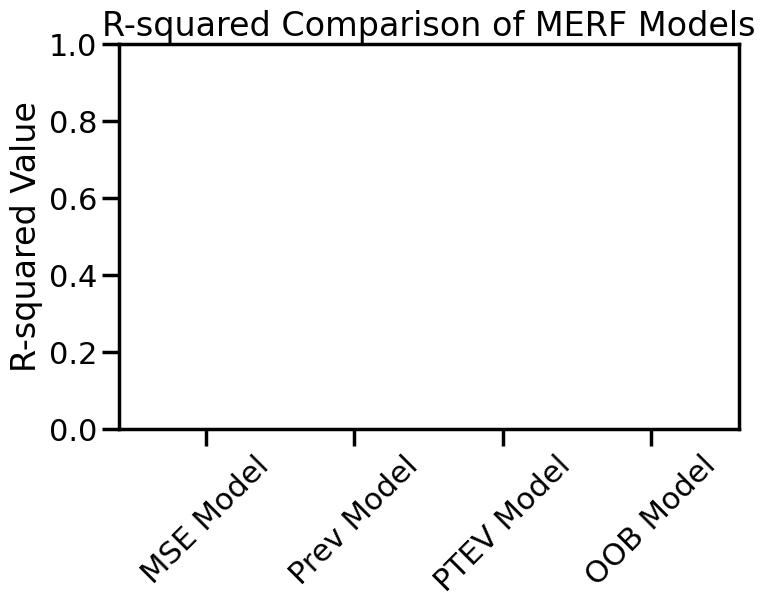

Best model: OOB Model with R-squared: -0.0368
R-squared values: {'MSE Model': -0.042370884135203735, 'Prev Model': -0.045667517631590826, 'PTEV Model': -0.0857466837543206, 'OOB Model': -0.03680863362522446}
Results DataFrame:
          Model  y_hat_new  R_squared  \
0    MSE Model  31.625490  -0.042371   
1    MSE Model  30.446766  -0.042371   
2    MSE Model  32.695505  -0.042371   
3    MSE Model  31.227146  -0.042371   
4    MSE Model  31.789204  -0.042371   
..         ...        ...        ...   
259  OOB Model  31.664168  -0.036809   
260  OOB Model  31.516425  -0.036809   
261  OOB Model  33.797285  -0.036809   
262  OOB Model  33.641031  -0.036809   
263  OOB Model  34.838677  -0.036809   

                            Top_15_Feature_Importances Cluster  
0    [{'Feature': 'TCA.cycle.VII..acetate.producers...       4  
1    [{'Feature': 'TCA.cycle.VII..acetate.producers...       4  
2    [{'Feature': 'TCA.cycle.VII..acetate.producers...       5  
3    [{'Feature': 'TCA.cycle.VI

In [9]:
train_l = train_long[only_pathway]
test_l = test_long[only_pathway]
output_dir = "/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/for_score_long"
r2_out = 'r2_only_pathway_merf_bmi_long_feb10.png'
feature_imp_out = 'fi_only_pathway_merf_bmi_long_feb10.png'
results_filename = 'merf_results_long_only_pathway.csv'

print("---------- Select predictors for training set ----------")
train_set = train_l
X = train_set.drop(['outcome_bmi_fnl', 'all_samples'], axis=1)
Y = train_set['outcome_bmi_fnl'].to_numpy()
clusters_train = train_set['all_samples'].to_numpy() 
Z = np.ones((train_set.shape[0], 1)) 

print("---------- Select predictors for test set ----------")
test_set = test_l
X_new = test_set.drop(['outcome_bmi_fnl', 'all_samples'], axis=1)[X.columns].astype(X.dtypes)
Y_new = test_set['outcome_bmi_fnl'].to_numpy()  
clusters_new = pd.Series(test_set['all_samples'])  
Z_new = np.ones((len(X_new), 1))

print("---------- Run MERF models ----------")
#r2_run2, fi_run2 = run_merf_analysis2(X, Y, Z, clusters_train,
#                             X_new, Y_new, Z_new, clusters_new, 
#                             long_df, output_dir, r2_out, feature_imp_out)
# Call the function
r2_values, results_df = run_merf_analysis2(
    X, Y, Z, clusters_train,
    X_new, Y_new, Z_new, clusters_new,
    long_df,
    output_dir, r2_out, feature_imp_out, results_filename
)

# Print the R-squared values and the results DataFrame
print("R-squared values:", r2_values)
print("Results DataFrame:\n", results_df)

## Merge the dataframes from above

In [10]:
# Step 1: Read all CSV files into a list of DataFrames
csv_files = glob.glob("/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/for_score_long/*.csv")  # Adjust the path to your CSV files
dataframes = []

for file in csv_files:
    model_name = file.split('/')[-1].replace('.csv', '')  # Get the model name from the file name
    df = pd.read_csv(file)
    
    # Step 2: Add a suffix to all columns except 'Cluster'
    df = df.rename(columns=lambda x: f"{x}_{model_name}" if x != 'Cluster' else x)
    dataframes.append(df)

# Step 3: Merge all DataFrames on the 'Cluster' column
merged_df = dataframes[0]  # Start with the first DataFrame

for df in dataframes[1:]:
    merged_df = merged_df.merge(df, on='Cluster', how='outer')  # Merge on 'Cluster'
print(merged_df.head()) 

  Model_merf_results_long_only_pathway  \
0                            MSE Model   
1                            MSE Model   
2                            MSE Model   
3                            MSE Model   
4                            MSE Model   

   y_hat_new_merf_results_long_only_pathway  \
0                                  31.62549   
1                                  31.62549   
2                                  31.62549   
3                                  31.62549   
4                                  31.62549   

   R_squared_merf_results_long_only_pathway  \
0                                 -0.042371   
1                                 -0.042371   
2                                 -0.042371   
3                                 -0.042371   
4                                 -0.042371   

  Top_15_Feature_Importances_merf_results_long_only_pathway  Cluster  \
0  [{'Feature': 'TCA.cycle.VII..acetate.producers...               4   
1  [{'Feature': 'TCA.cycle.VII..aceta

In [11]:
# Step 1: Identify columns that start with "Model"
model_columns = [col for col in merged_df.columns if col.startswith('Model')]

# Step 2: Filter for rows that belong to the OOB model
# Replace 'OOB' with the actual identifier used in your DataFrame to denote OOB models
oob_df = merged_df[merged_df[model_columns].apply(lambda row: row.str.contains('OOB', na=False).any(), axis=1)]

# Step 3: Select the "Cluster" column and columns that start with "y_hat_new"
filtered_df = oob_df[['Cluster'] + [col for col in oob_df.columns if col.startswith('y_hat_new')]]

# Display the filtered DataFrame
print(filtered_df.head())

    Cluster  y_hat_new_merf_results_long_only_pathway  \
6         4                                  31.62549   
7         4                                  31.62549   
14        4                                  31.62549   
15        4                                  31.62549   
22        4                                  31.62549   

    y_hat_new_merf_results_long_only_taxa  \
6                               31.803823   
7                               31.803823   
14                              31.803823   
15                              31.803823   
22                              31.803823   

    y_hat_new_merf_results_long_only_micom  \
6                                31.273596   
7                                31.273596   
14                               31.273596   
15                               31.273596   
22                               31.273596   

    y_hat_new_merf_results_long_meta_grs  \
6                              32.463641   
7                    

## Merge predicted outcomes with test set 

In [ ]:
test_short = test_long[['all_samples', 'outcome_bmi_fnl']] 
merged_df = pd.merge(filtered_df, test_long, left_on='Cluster', right_on='all_samples', how='inner')  


In [12]:
# Save the merged DataFrame to a CSV file
merged_df.to_csv('/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/merf_dfs/predicted_test_dfs/feb10_long_predicted_merged_df.csv', index=False)  # Specify your desired file path


## 1.2 trying Meta + Genetic info from omic DF
PTEV model
First 5 columns for the lowest mean_ptev_score:
n_estimators         500.00
max_depth               NaN
min_samples_split      0.05
max_iter               2.00
n_splits              10.00
Name: 20, dtype: float64

In [ ]:
train_l = train_long[meta_grs]
test_l = test_long[meta_grs]
output_dir = "/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/for_score_long"
r2_out = 'r2_meta_grs_merf_bmi_long_feb10_all.png'
feature_imp_out = 'fi_meta_grs_merf_bmi_long_feb10_all.png'
results_filename = 'merf_results_long_meta_grs.csv'

print("---------- Select predictors for training set ----------")
train_set = train_l
X = train_set.drop(['outcome_bmi_fnl', 'all_samples'], axis=1)
Y = train_set['outcome_bmi_fnl'].to_numpy()
clusters_train = train_set['all_samples'].to_numpy() 
Z = np.ones((train_set.shape[0], 1)) 

print("---------- Select predictors for test set ----------")
test_set = test_l
X_new = test_set.drop(['outcome_bmi_fnl', 'all_samples'], axis=1)[X.columns].astype(X.dtypes)
Y_new = test_set['outcome_bmi_fnl'].to_numpy()  
clusters_new = pd.Series(test_set['all_samples'])  
Z_new = np.ones((len(X_new), 1))

print("---------- Run MERF models ----------")
#r2_run2, fi_run2 = run_merf_analysis2(X, Y, Z, clusters_train,
#                             X_new, Y_new, Z_new, clusters_new, 
#                             long_df, output_dir, r2_out, feature_imp_out)
# Call the function
r2_values, results_df = run_merf_analysis2(
    X, Y, Z, clusters_train,
    X_new, Y_new, Z_new, clusters_new,
    long_df,
    output_dir, r2_out, feature_imp_out, results_filename
)

# Print the R-squared values and the results DataFrame
print("R-squared values:", r2_values)
print("Results DataFrame:\n", results_df)

print("---------- Run best MERF 🧮 ----------")# Define the parameter grid list
# param_grid_list = [
#     {'n_estimators': 500, 'max_depth': None, 
#      'min_samples_split': 0.05, 'max_iter': 2}
# ]
# # Call the run_merf function with the required parameters
# only_meta_grs = run_merf(X, Y, Z, clusters_train,
#                      X_new, Y_new, Z_new, clusters_new, 
#                      param_grid_list, results_name="only_meta_grs_results")
# # View the "only_meta" output
# print("Viewing the 'only_meta' output:")
# for result in only_meta_grs:
#     print(f"Model Parameters: {result['params']}")
#     print(f"R-squared: {result['r2']:.4f}")
#     print("Feature Importances:")
#     for feature, importance in zip(X.columns, result['feature_importances']):
#         print(f"{feature}: {importance:.4f}")
#     print("\n")

## 1.3 trying Meta + Genetic + Taxa info from omic DF

First 5 columns for the lowest mean_ptev_score:
n_estimators         500.00
max_depth               NaN
min_samples_split      0.05
max_iter               2.00
n_splits              10.00
Name: 20, dtype: float64

First 5 columns for the lowest mean_ptev_score:
n_estimators         100.00
max_depth               NaN
min_samples_split      0.05
max_iter               2.00
n_splits              10.00
Name: 2, dtype: float64

In [ ]:
train_l = train_long[meta_grs_taxa]
test_l = test_long[meta_grs_taxa_test]
output_dir = "/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/merf_plots/long_combined"
r2_out = 'r2_meta_grs_taxa_merf_bmi_long_feb6.png'
feature_imp_out = 'fi_meta_grs_taxa_merf_bmi_long_feb6.png'

print("---------- Select predictors for training set ----------")
train_set = train_l
X = train_set.drop(['outcome_bmi_fnl', 'all_samples'], axis=1)
Y = train_set['outcome_bmi_fnl'].to_numpy()
clusters_train = train_set['all_samples'].to_numpy() 
Z = np.ones((train_set.shape[0], 1)) 

print("---------- Select predictors for test set ----------")
test_set = test_l
X_new = test_set.drop(['outcome_bmi_fnl', 'all_samples'], axis=1)[X.columns].astype(X.dtypes)
Y_new = test_set['outcome_bmi_fnl'].to_numpy()  
clusters_new = pd.Series(test_set['all_samples'])  
Z_new = np.ones((len(X_new), 1))

print("---------- Run MERF models ----------")
#run_merf_analysis(X, Y, Z, clusters_train, 
#                  X_new, Y_new, Z_new, clusters_new, 
#                  long_df, output_dir, r2_out, feature_imp_out)

r2_run3, fi_run3 = run_merf_analysis2(X, Y, Z, clusters_train,
                             X_new, Y_new, Z_new, clusters_new, 
                             long_df, output_dir, r2_out, feature_imp_out)

print("---------- Run best MERF 🧮 ----------")
# param_grid_list = [
#     {'n_estimators': 500, 'max_depth': None, 
#      'min_samples_split': 0.05, 'max_iter': 2}
# ]
# # Call the run_merf function with the required parameters
# meta_grs_tax = run_merf(X, Y, Z, clusters_train,
#                      X_new, Y_new, Z_new, clusters_new, 
#                      param_grid_list, results_name="meta_grs_tax_results")
# # View the "only_meta" output
# print("Viewing the 'only_meta' output:")
# for result in meta_grs_tax:
#     print(f"Model Parameters: {result['params']}")
#     print(f"R-squared: {result['r2']:.4f}")
#     print("Feature Importances:")
#     for feature, importance in zip(X.columns, result['feature_importances']):
#         print(f"{feature}: {importance:.4f}")
#     print("\n")
# # End of Selection

## 1.4 trying Meta + Genetic + Taxa + Functional info from omic DF

lowest mean_ptev_score:
n_estimators         500.00
max_depth               NaN
min_samples_split      0.05
max_iter               2.00
n_splits              10.00
Name: 20, dtype: float64

First 5 columns for the lowest mean_prev_score:
n_estimators         500.00
max_depth               NaN
min_samples_split      0.15
max_iter               2.00
n_splits               5.00
Name: 31, dtype: float64

In [ ]:
train_l = train_long[meta_grs_taxa_functional]
test_l = test_long[meta_grs_taxa_functional_test]
# Check for duplicate column names in test_l
duplicates_test = test_l.columns[test_l.columns.duplicated()].unique()
duplicates_train = train_l.columns[train_l.columns.duplicated()].unique()
# Remove duplicate columns
test_l = test_l.loc[:, ~test_l.columns.duplicated()]
train_l = train_l.loc[:, ~train_l.columns.duplicated()]
output_dir = "/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/merf_plots/long_combined"
r2_out = 'r2_meta_grs_taxa_functional_merf_bmi_long_feb6.png'
feature_imp_out = 'fi_meta_grs_taxa_functional_merf_bmi_long_feb6.png'

print("---------- Select predictors for training set ----------")
train_set = train_l
X = train_set.drop(['outcome_bmi_fnl', 'all_samples'], axis=1)
Y = train_set['outcome_bmi_fnl'].to_numpy()
clusters_train = train_set['all_samples'].to_numpy() 
Z = np.ones((train_set.shape[0], 1)) 

print("---------- Select predictors for test set ----------")
test_set = test_l
X_new = test_set.drop(['outcome_bmi_fnl', 'all_samples'], axis=1)[X.columns].astype(X.dtypes)
Y_new = test_set['outcome_bmi_fnl'].to_numpy()  
clusters_new = pd.Series(test_set['all_samples'])  
Z_new = np.ones((len(X_new), 1))

print("---------- Run MERF models ----------")
#run_merf_analysis(X, Y, Z, clusters_train, 
#                  X_new, Y_new, Z_new, clusters_new, 
#                  long_df, output_dir, r2_out, feature_imp_out)
# Run the analysis multiple times
r2_run4, fi_run4 = run_merf_analysis2(X, Y, Z, clusters_train,
                             X_new, Y_new, Z_new, clusters_new, 
                             long_df, output_dir, r2_out, feature_imp_out)

print("---------- Run best MERF 🧮 ----------")
param_grid_list = [
    {'n_estimators': 500, 'max_depth': None, 
     'min_samples_split': 0.05, 'max_iter': 2}
]
# Call the run_merf function with the required parameters
#meta_grs_tax_func = run_merf(X, Y, Z, clusters_train,
#                     X_new, Y_new, Z_new, clusters_new, 
#                     param_grid_list, results_name="meta_grs_tax_func_results")
# View the "only_meta" output
#print("Viewing the 'only_meta' output:")
#for result in meta_grs_tax_func:
#    print(f"Model Parameters: {result['params']}")
#    print(f"R-squared: {result['r2']:.4f}")
#    print("Feature Importances:")
#    for feature, importance in zip(X.columns, result['feature_importances']):
#        print(f"{feature}: {importance:.4f}")
#    print("\n")

## 1.5 all but meta omic df 

First 5 columns for the lowest mean_mse_score:
n_estimators         500.0
max_depth              NaN
min_samples_split      0.1
max_iter              10.0
n_splits              10.0
Name: 29, dtype: float64

First 5 columns for the highest oob_score:
n_estimators         1000.00
max_depth                NaN
min_samples_split       0.05
max_iter               10.00
n_splits               10.00
Name: 41, dtype: float64

In [ ]:
train_l = train_long.drop(all_but_meta, axis = 1)
test_l = test_long.drop(all_but_meta, axis = 1)
output_dir = "/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/merf_plots/long_combined"
r2_out = 'r2_all_but_meta_merf_bmi_long_feb6.png'
feature_imp_out = 'fi_all_but_meta_merf_bmi_long_feb6.png'

print("---------- Select predictors for training set ----------")
train_set = train_l
X = train_set.drop(['outcome_bmi_fnl', 'all_samples'], axis=1)
Y = train_set['outcome_bmi_fnl'].to_numpy()
clusters_train = train_set['all_samples'].to_numpy() 
Z = np.ones((train_set.shape[0], 1)) 

print("---------- Select predictors for test set ----------")
test_set = test_l
X_new = test_set.drop(['outcome_bmi_fnl', 'all_samples'], axis=1)[X.columns].astype(X.dtypes)
Y_new = test_set['outcome_bmi_fnl'].to_numpy()  
clusters_new = pd.Series(test_set['all_samples'])  
Z_new = np.ones((len(X_new), 1))

print("---------- Run MERF models ----------")
#run_merf_analysis(X, Y, Z, clusters_train, 
#                  X_new, Y_new, Z_new, clusters_new, 
#                  long_df, output_dir, r2_out, feature_imp_out)
r2_run5, fi_run5 = run_merf_analysis2(X, Y, Z, clusters_train,
                             X_new, Y_new, Z_new, clusters_new, 
                             long_df, output_dir, r2_out, feature_imp_out)

print("---------- Run best MERF 🧮 ----------")
# param_grid_list = [
#     {'n_estimators': 500, 'max_depth': None, 
#      'min_samples_split': 0.05, 'max_iter': 2}
# ]
# # Call the run_merf function with the required parameters
# grs_tax_func_micom = run_merf(X, Y, Z, clusters_train,
#                      X_new, Y_new, Z_new, clusters_new, 
#                      param_grid_list, results_name="grs_tax_func_micom")
# # View the "only_meta" output
# print("Viewing the 'only_meta' output:")
# for result in grs_tax_func_micom:
#     print(f"Model Parameters: {result['params']}")
#     print(f"R-squared: {result['r2']:.4f}")
#     print("Feature Importances:")
#     for feature, importance in zip(X.columns, result['feature_importances']):
#         print(f"{feature}: {importance:.4f}")
#     print("\n")
# # End of Selection

## 1.6 All omics 

First 5 columns for the lowest mean_ptev_score:
n_estimators         500.00
max_depth               NaN
min_samples_split      0.05
max_iter               2.00
n_splits              10.00
Name: 20, dtype: float64

First 5 columns for the lowest mean_ptev_score:
n_estimators         100.00
max_depth               NaN
min_samples_split      0.05
max_iter               2.00
n_splits              10.00
Name: 2, dtype: float64

In [ ]:
output_dir = "/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/merf_plots/long_combined"
r2_out = 'r2_all_omics_merf_bmi_long_feb6.png'
feature_imp_out = 'fi_all_omics_merf_bmi_long_feb6.png'

print("---------- Select predictors for training set ----------")
train_set = train_long
X = train_set.drop(['outcome_bmi_fnl', 'all_samples'], axis=1)
Y = train_set['outcome_bmi_fnl'].to_numpy()
clusters_train = train_set['all_samples'].to_numpy() 
Z = np.ones((train_set.shape[0], 1)) 

print("---------- Select predictors for test set ----------")
test_set = test_long
X_new = test_set.drop(['outcome_bmi_fnl', 'all_samples'], axis=1)[X.columns].astype(X.dtypes)
Y_new = test_set['outcome_bmi_fnl'].to_numpy()  
clusters_new = pd.Series(test_set['all_samples'])  
Z_new = np.ones((len(X_new), 1))

print("---------- Run MERF models ----------")
#run_merf_analysis(X, Y, Z, clusters_train, 
#                  X_new, Y_new, Z_new, clusters_new, 
#                  long_df, output_dir, r2_out, feature_imp_out)

r2_run6, fi_run6 = run_merf_analysis2(X, Y, Z, clusters_train,
                             X_new, Y_new, Z_new, clusters_new, 
                             long_df, output_dir, r2_out, feature_imp_out)

print("---------- Run best MERF 🧮 ----------")
param_grid_list = [
    {'n_estimators': 100, 'max_depth': None, 
     'min_samples_split': 0.05, 'max_iter': 2}
]
# Call the run_merf function with the required parameters
# all_omic = run_merf(X, Y, Z, clusters_train,
#                      X_new, Y_new, Z_new, clusters_new, 
#                      param_grid_list, results_name="grs_tax_func_micom")
# # View the "only_meta" output
# print("Viewing the 'only_meta' output:")
# for result in all_omic:
#     print(f"Model Parameters: {result['params']}")
#     print(f"R-squared: {result['r2']:.4f}")
#     print("Feature Importances:")
#     for feature, importance in zip(X.columns, result['feature_importances']):
#         print(f"{feature}: {importance:.4f}")
#     print("\n")

# Now looking at Delta models 

In [ ]:
print("test delta: ", list(test_delta.shape))
print("train delta: ", list(train_delta.shape))
print("test delta: ", list(test_delta.columns))
print("train delta: ", list(train_delta.columns))

In [ ]:
# Find the column numbers for "proton" and "Carbon.dioxide" in train_set
proton_column = train_delta.columns.get_loc("proton")
carbon_dioxide_column = train_delta.columns.get_loc("Carbon.dioxide")
proton_column_test = test_delta.columns.get_loc("proton")
carbon_dioxide_column_test = test_delta.columns.get_loc("Carbon.dioxide")
print("Column number for 'proton': ", proton_column)
print("Column number for 'Carbon.dioxide': ", carbon_dioxide_column)

# Columns to KEEP for only meta 
meta_keep = ['subject_id','BMI', 'randomized_group', 'sex', 'race', 'age', 'HDL', 'homo_ir', 'insulin', 'LDL', 'tgcyd']

# Columns to KEEP for only meta + GRS + taxa
meta_grs_taxa = meta_keep + [col for col in train_delta.columns if col.startswith("g__")]
meta_grs_taxa_test = meta_keep + [col for col in test_delta.columns if col.startswith("g__")]

# Columns to KEEP for only meta + GRS + taxa + pathway/functional 
meta_grs_taxa_functional = meta_grs_taxa + [col for col in train_delta.columns if col not in train_delta.columns[proton_column:carbon_dioxide_column+1]]
meta_grs_taxa_functional_test = meta_grs_taxa_test + [col for col in test_delta.columns if col not in test_delta.columns[proton_column_test:carbon_dioxide_column_test+1]]

# Columns to DROP for only GRS + taxa + pathway/functional + micom (no meta)
all_but_meta = ['randomized_group', 'sex', 'race', 'age', 'HDL', 'homo_ir', 'insulin', 'LDL', 'tgcyd', 'Weight', 'CRP', 'cholesterol', 'ghrelin', 'HbA1C', 'leptin', 'peptide_yy', 'range']

## 2.1 Only Meta Delta 

In [ ]:
# Check for missing columns in train_delta
missing_columns = [col for col in meta_keep if col not in train_delta.columns]

if missing_columns:
    print("Missing columns in train_delta:", missing_columns)
else:
    print("All columns in meta_keep are present in train_delta.")

In [ ]:
train_l = train_delta[meta_keep]
test_l = test_delta[meta_keep]
output_dir = "/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/merf_plots/long_combined"
r2_out = 'r2_only_meta_merf_bmi_delta_feb7.png'
feature_imp_out = 'fi_only_meta_merf_bmi_delta_feb7.png'

print("---------- Select predictors for training set ----------")
train_set = train_l
X = train_set.drop(['BMI','subject_id'], axis=1)
Y = train_set['BMI'].to_numpy()
clusters_train = train_set['subject_id'].to_numpy() 
Z = np.ones((train_set.shape[0], 1)) 

print("---------- Select predictors for test set ----------")
test_set = test_l
X_new = test_set.drop(['BMI', 'subject_id'], axis=1)[X.columns].astype(X.dtypes)
Y_new = test_set['BMI'].to_numpy()  
clusters_new = pd.Series(test_set['subject_id'])  
Z_new = np.ones((len(X_new), 1))

print("---------- Run MERF models ----------")
#run_merf_analysis(X, Y, Z, clusters_train, 
#                  X_new, Y_new, Z_new, clusters_new, 
#                  meta_df, output_dir, r2_out, feature_imp_out)

r2_delta_run1, fi_delta_run1 = run_merf_analysis2(X, Y, Z, clusters_train,
                             X_new, Y_new, Z_new, clusters_new, 
                             long_df, output_dir, r2_out, feature_imp_out)

## 2.2 Ok now include meta and taxa deltas 

There is no change in bmi_prs so that is not included in the delta models 

In [ ]:
train_l = train_delta[meta_grs_taxa]
test_l = test_delta[meta_grs_taxa_test]
output_dir = "/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/merf_plots/long_combined"
r2_out = 'r2_meta_taxa_merf_bmi_delta_feb7.png'
feature_imp_out = 'fi_meta_taxa_merf_bmi_delta_feb7.png'

print("---------- Select predictors for training set ----------")
train_set = train_l
X = train_set.drop(['BMI','subject_id'], axis=1)
Y = train_set['BMI'].to_numpy()
clusters_train = train_set['subject_id'].to_numpy() 
Z = np.ones((train_set.shape[0], 1)) 

print("---------- Select predictors for test set ----------")
test_set = test_l
X_new = test_set.drop(['BMI', 'subject_id'], axis=1)[X.columns].astype(X.dtypes)
Y_new = test_set['BMI'].to_numpy()  
clusters_new = pd.Series(test_set['subject_id'])  
Z_new = np.ones((len(X_new), 1))

print("---------- Run MERF models ----------")
#run_merf_analysis(X, Y, Z, clusters_train, 
#                  X_new, Y_new, Z_new, clusters_new, 
#                  meta_df, output_dir, r2_out, feature_imp_out)

r2_delta_run2, fi_delta_run2 = run_merf_analysis2(X, Y, Z, clusters_train,
                             X_new, Y_new, Z_new, clusters_new, 
                             delta_df, output_dir, r2_out, feature_imp_out)

## 2.3 Delta variables Meta + Taxa + Functional

In [16]:
train_l = train_delta[meta_grs_taxa]
test_l = test_delta[meta_grs_taxa_test]

# Check for duplicate column names in train_l and test_l
duplicates_train = train_l.columns[train_l.columns.duplicated()].unique()
duplicates_test = test_l.columns[test_l.columns.duplicated()].unique()

# Count of duplicate columns
num_duplicates_train = len(duplicates_train)
num_duplicates_test = len(duplicates_test)

# Remove duplicate columns from train_l
train_l = train_l.loc[:, ~train_l.columns.duplicated()]
test_l = test_l.loc[:, ~test_l.columns.duplicated()]

In [ ]:
train_l = train_delta[meta_grs_taxa_functional]
test_l = test_delta[meta_grs_taxa_functional_test]

# Check for duplicate column names in train_l and test_l
duplicates_train = train_l.columns[train_l.columns.duplicated()].unique()
duplicates_test = test_l.columns[test_l.columns.duplicated()].unique()

# Count of duplicate columns
num_duplicates_train = len(duplicates_train)
num_duplicates_test = len(duplicates_test)

# Remove duplicate columns from train_l
train_l = train_l.loc[:, ~train_l.columns.duplicated()]
test_l = test_l.loc[:, ~test_l.columns.duplicated()]

print("Columns in train_l DataFrame:")
print(list(train_l.columns))  # Convert to list for better readability

In [ ]:
train_l = train_delta[meta_grs_taxa_functional]
test_l = test_delta[meta_grs_taxa_functional_test]

# Check for duplicate column names in train_l and test_l
duplicates_train = train_l.columns[train_l.columns.duplicated()].unique()
duplicates_test = test_l.columns[test_l.columns.duplicated()].unique()

# Count of duplicate columns
num_duplicates_train = len(duplicates_train)
num_duplicates_test = len(duplicates_test)

# Remove duplicate columns from train_l
train_l = train_l.loc[:, ~train_l.columns.duplicated()]
test_l = test_l.loc[:, ~test_l.columns.duplicated()]

output_dir = "/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/merf_plots/long_combined"
r2_out = 'r2_meta_taxa_functional_merf_bmi_delta_feb7.png'
feature_imp_out = 'fi_meta_taxa_functional_merf_bmi_delta_feb7.png'

print("---------- Select predictors for training set ----------")
train_set = train_l
X = train_set.drop(['BMI','Weight','subject_id', 'CRP', 'cholesterol', 'ghrelin', 'HbA1C', 'leptin', 'peptide_yy', 'range'], axis=1)
Y = train_set['BMI'].to_numpy()
clusters_train = train_set['subject_id'].to_numpy() 
Z = np.ones((train_set.shape[0], 1)) 

print("---------- Select predictors for test set ----------")
test_set = test_l
X_new = test_set.drop(['BMI', 'Weight','subject_id', 'CRP', 'cholesterol', 'ghrelin', 'HbA1C', 'leptin', 'peptide_yy', 'range'], axis=1)[X.columns].astype(X.dtypes)
Y_new = test_set['BMI'].to_numpy()  
clusters_new = pd.Series(test_set['subject_id'])  
Z_new = np.ones((len(X_new), 1))

print("---------- Run MERF models ----------")
#run_merf_analysis(X, Y, Z, clusters_train, 
#                  X_new, Y_new, Z_new, clusters_new, 
#                  meta_df, output_dir, r2_out, feature_imp_out)

r2_delta_run3, fi_delta_run3 = run_merf_analysis2(X, Y, Z, clusters_train,
                             X_new, Y_new, Z_new, clusters_new, 
                             delta_df, output_dir, r2_out, feature_imp_out)

## 2.4 all delta omics except meta 

In [ ]:


print("test longitudinal: ", list(test_l.columns))
print("train longitudinal: ", list(train_l.columns))

# Print duplicated column names in test_l
duplicates_test = test_l.columns[test_l.columns.duplicated()].unique()
print("Duplicated columns in test_l: ", duplicates_test)

# Print duplicated column names in train_l
duplicates_train = train_l.columns[train_l.columns.duplicated()].unique()
print("Duplicated columns in train_l: ", duplicates_train)


In [ ]:
train_l = train_delta.drop(all_but_meta, axis = 1)
test_l = test_delta.drop(all_but_meta, axis = 1)

output_dir = "/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/merf_plots/long_combined"
r2_out = 'r2_taxa_functional_micom_merf_bmi_delta_feb7.png'
feature_imp_out = 'fi_taxa_functional_micom_merf_bmi_delta_feb7.png'

print("---------- Select predictors for training set ----------")
train_set = train_l
X = train_set.drop(['BMI','subject_id', 'range'], axis=1)
Y = train_set['BMI'].to_numpy()
clusters_train = train_set['subject_id'].to_numpy() 
Z = np.ones((train_set.shape[0], 1)) 

print("---------- Select predictors for test set ----------")
test_set = test_l
X_new = test_set.drop(['BMI','subject_id', 'range'], axis=1)[X.columns].astype(X.dtypes)
Y_new = test_set['BMI'].to_numpy()  
clusters_new = pd.Series(test_set['subject_id'])  
Z_new = np.ones((len(X_new), 1))

print("---------- Run MERF models ----------")
#run_merf_analysis(X, Y, Z, clusters_train, 
#                  X_new, Y_new, Z_new, clusters_new, 
#                  meta_df, output_dir, r2_out, feature_imp_out)

r2_delta_run4, fi_delta_run4 = run_merf_analysis2(X, Y, Z, clusters_train,
                             X_new, Y_new, Z_new, clusters_new, 
                             delta_df, output_dir, r2_out, feature_imp_out)

## 2.5 all delta varibles 

In [ ]:
output_dir = "/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/merf_plots/long_combined"
r2_out = 'r2_all_omic_merf_bmi_delta_feb7.png'
feature_imp_out = 'fi_all_omic_merf_bmi_delta_feb7.png'

print("---------- Select predictors for training set ----------")
train_set = train_delta
X = train_set.drop(['BMI','Weight','subject_id', 'CRP', 'cholesterol', 'ghrelin', 'HbA1C', 'leptin', 'peptide_yy', 'range'], axis=1)
Y = train_set['BMI'].to_numpy()
clusters_train = train_set['subject_id'].to_numpy() 
Z = np.ones((train_set.shape[0], 1)) 

print("---------- Select predictors for test set ----------")
test_set = test_delta
X_new = test_set.drop(['BMI','Weight','subject_id', 'CRP', 'cholesterol', 'ghrelin', 'HbA1C', 'leptin', 'peptide_yy', 'range'], axis=1)[X.columns].astype(X.dtypes)
Y_new = test_set['BMI'].to_numpy()  
clusters_new = pd.Series(test_set['subject_id'])  
Z_new = np.ones((len(X_new), 1))

print("---------- Run MERF models ----------")
#run_merf_analysis(X, Y, Z, clusters_train, 
#                  X_new, Y_new, Z_new, clusters_new, 
#                  meta_df, output_dir, r2_out, feature_imp_out)

#r2_delta_run5 = run_merf_analysis2(X, Y, Z, clusters_train,
#                             X_new, Y_new, Z_new, clusters_new, 
#                             delta_df, output_dir, r2_out, feature_imp_out)

r2_delta_run5, fi_delta_run5 = run_merf_analysis2(X, Y, Z, clusters_train, 
                                              X_new, Y_new, Z_new, clusters_new, 
                                              delta_df, output_dir, r2_out, feature_imp_out)

# Now you can use `top_features` for plotting or further analysis

# Comparing all models above 

In [21]:
def compare_r2_values1(model_names, *r2_dicts):
    # Create a DataFrame to hold the R-squared values
    r2_comparison_df = pd.DataFrame(r2_dicts).T
    r2_comparison_df.columns = model_names 
    print(r2_comparison_df.head(10).columns[:10])
    print(r2_comparison_df.head(10))

    # Sort the DataFrame by R-squared values in descending order
    r2_comparison_df = r2_comparison_df.sort_values(by=model_names, ascending=False)

    # Set up the bar positions
    num_runs = len(r2_comparison_df.columns)
    bar_width = 0.15  # Width of each bar
    x = np.arange(len(r2_comparison_df))  # The label locations

    # Create a color map for the models
    colors = plt.cm.viridis(np.linspace(0, 1, num_runs))

    # Create bars for each model in each run
    for i in range(num_runs):
        plt.bar(x + i * bar_width, r2_comparison_df.iloc[:, i],  # Use plt.bar for vertical bars
                 width=bar_width, label=model_names[i], color=colors[i])  # Use model names for labels

    # Add labels, title, and custom x-axis tick labels
    plt.ylabel('R-squared Value')  # Change to y-label
    plt.title('R-squared Comparison of Different Runs')
    plt.ylim(0, 0.55)  # Assuming R-squared values are between 0 and 1
    plt.xticks(x + bar_width * (num_runs - 1) / 2, r2_comparison_df.index)  # Center the x-ticks
    plt.legend(title='Models', loc='upper right', fontsize=10, 
               title_fontsize=10, ncol = 2, frameon=False)
    plt.tight_layout()
    plt.show()

In [ ]:
model_names = ['Only Meta', 'Meta GRS', 
               'Meta GRS Tax', 'Meta GRS Tax Func', 
               'All But Meta', 'All Omic']
compare_r2_values1(model_names, r2_run1, r2_run2, r2_run3, r2_run4, r2_run5, r2_run6)

In [ ]:
model_names_delta = ['Only Meta Delta',  
               'Meta Tax Delta', 'Meta Tax Func Delta', 
               'All But Meta Delta', 'All Omic Delta']
compare_r2_values1(model_names_delta, r2_delta_run1, r2_delta_run2, 
                   r2_delta_run3, r2_delta_run4, r2_delta_run5)

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

def compare_r2_values2(model_names, *r2_dicts):
    # Create a DataFrame to hold the R-squared values
    r2_comparison_df = pd.DataFrame(r2_dicts).T
    r2_comparison_df.columns = model_names 

    # Reset index to use row names as a column
    r2_comparison_df.reset_index(inplace=True)
    r2_comparison_df = r2_comparison_df.melt(id_vars='index', var_name='Model', value_name='R-squared')

    # Rename the 'index' column to 'Metric' for clarity
    r2_comparison_df.rename(columns={'index': 'Metric'}, inplace=True)

    # Create the bar plot
    plt.figure(figsize=(12, 8))
    sns.barplot(data=r2_comparison_df, x='Model', y='R-squared', hue='Metric', palette='viridis')

    # Add labels and title
    plt.ylabel('R-squared Value')
    plt.title('R-squared Comparison of Different Models')
    plt.ylim(0.0, 0.35)  # Adjust y-limits based on your data range
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='hyperparameter optimization settings', loc='upper right', fontsize=9, 
               title_fontsize=8, ncol = 4, frameon=False)
    plt.tight_layout()
    plt.show()

In [ ]:
model_names = ['Only Meta', 'Meta GRS', 
               'Meta GRS Tax', 'Meta GRS Tax Func', 
               'All But Meta', 'All Omic']
compare_r2_values2(model_names, r2_run1, r2_run2, r2_run3, r2_run4, r2_run5, r2_run6)

In [ ]:
compare_r2_values2(model_names_delta, r2_delta_run1, r2_delta_run2, 
                   r2_delta_run3, r2_delta_run4, r2_delta_run5)

In [ ]:
model_names_both = ['Only Meta Long', 'Meta GRS Long', 
               'Meta GRS Tax Long', 'Meta GRS Tax Func Long', 
               'All But Meta Long', 'All Omic Long', 
               'Only Meta Delta', 'Meta Tax Delta', 'Meta Tax Func Delta', 
               'All But Meta Delta', 'All Omic Delta']

compare_r2_values2(model_names_both, 
                   r2_run1, r2_run2, r2_run3, r2_run4, r2_run5, r2_run6,
                   r2_delta_run1, r2_delta_run2, 
                   r2_delta_run3, r2_delta_run4, r2_delta_run5)

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

def compare_r2_values3(model_names, *r2_dicts):
    # Create a DataFrame to hold the R-squared values
    r2_comparison_df = pd.DataFrame(r2_dicts).T
    r2_comparison_df.columns = model_names 

    # Reset index to use row names as a column
    r2_comparison_df.reset_index(inplace=True)
    r2_comparison_df = r2_comparison_df.melt(id_vars='index', var_name='Model', value_name='R-squared')

    # Rename the 'index' column to 'Metric' for clarity
    r2_comparison_df.rename(columns={'index': 'Metric'}, inplace=True)

    # Sort the DataFrame by 'Model' and then by 'R-squared' in descending order
    r2_comparison_df = r2_comparison_df.sort_values(by=['Metric', 'R-squared'], ascending=[True, False])

    # Create the bar plot
    plt.figure(figsize=(12, 8))
    sns.barplot(data=r2_comparison_df, x='Model', y='R-squared', hue='Metric', palette='viridis')

    # Add labels and title
    plt.ylabel('R-squared Value')
    plt.title('R-squared Comparison of Different Models')
    plt.ylim(-0.2, 0.2)  # Adjust y-limits based on your data range
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='hyperparameter optimization settings', loc='upper right', fontsize=10, 
               title_fontsize=10, ncol = 2, frameon=False)
    plt.tight_layout()
    plt.show()

In [ ]:
model_names = ['Only Meta', 'Meta GRS', 
               'Meta GRS Tax', 'Meta GRS Tax Func', 
               'All But Meta', 'All Omic']
compare_r2_values3(model_names, r2_run1, r2_run2, r2_run3, r2_run4, r2_run5, r2_run6)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_feature_importance(dataframes):
    # Combine all DataFrames into a single DataFrame
    combined_df = pd.concat(dataframes)
    
    # Create a plot
    plt.figure(figsize=(12, 8))
    bar_width = 0.08
    # Plot each model's feature importance
    for model in combined_df['Model'].unique():
        model_data = combined_df[combined_df['Model'] == model]
        plt.bar(model_data['Feature'], model_data['Importance'], label=model)
    
    # Add labels and title
    plt.xlabel('Features', fontsize=10)
    plt.ylabel('Importance', fontsize=10)
    plt.title('Feature Importance by Model')
    plt.xticks(rotation=45, fontsize=9)
    plt.legend(title='Model', fontsize=9, ncol=2)
    plt.tight_layout()
    
    # Show the plot
    plt.show()

# Example usage
feature_importance_dfs = [fi_run1, fi_run2, fi_run3, fi_run4, fi_run5, fi_run6, fi_delta_run1, fi_delta_run2]
plot_feature_importance(feature_importance_dfs)

In [78]:
def plot_feature_importance(dataframes):
    combined_df = pd.concat(dataframes) # Combine all DataFrames 
    # Filter features with importance < 0.02 & negative importance in all models
    combined_df = combined_df[(combined_df['Importance'] >= 0.02) & 
                          (combined_df.groupby('Feature')['Importance'].transform('min') >= 0)]
    plt.figure(figsize=(12, 8))
    bar_width = 0.15 
    num_models = len(combined_df['Model'].unique())
    
    # Get unique features
    features = combined_df['Feature'].unique()
    x = np.arange(len(features))  # The label locations

    # Plot each model's feature importance
    for i, model in enumerate(combined_df['Model'].unique()):
        model_data = combined_df[combined_df['Model'] == model]
        
        # Ensure heights only includes matching features
        heights = model_data[model_data['Feature'].isin(features)]['Importance'] 
        model_x = x[:len(heights)] + i * bar_width  # Adjust x-coordinates for the current model
        plt.bar(model_x, heights, width=bar_width, label=model)
    
    # Add labels and title
    plt.xlabel('Features', fontsize=10)
    plt.ylabel('Importance', fontsize=10)
    plt.title('Feature Importance by Model')
    plt.xticks(x + bar_width * (num_models - 1) / 2, features, rotation=45, fontsize=9)  # Center x-ticks
    plt.legend(title='Model', fontsize=9, ncol=2)
    plt.tight_layout()
    plt.ylim(0, 0.6)
    plt.show()

In [81]:
def plot_feature_importance(dataframes, model_labels):
    combined_df = pd.concat(dataframes)  # Combine all DataFrames 
    # Filter features with importance < 0.02 & negative importance in all models
    combined_df = combined_df[(combined_df['Importance'] >= 0.02) & 
                              (combined_df.groupby('Feature')['Importance'].transform('min') >= 0)]
    plt.figure(figsize=(12, 8))
    bar_width = 0.15 
    num_models = len(combined_df['Model'].unique())
    
    # Get unique features
    features = combined_df['Feature'].unique()
    x = np.arange(len(features))  # The label locations

    # Plot each model's feature importance
    for i, model in enumerate(combined_df['Model'].unique()):
        model_data = combined_df[combined_df['Model'] == model]
        
        # Ensure heights only includes matching features
        heights = model_data[model_data['Feature'].isin(features)]['Importance'] 
        model_x = x[:len(heights)] + i * bar_width  # Adjust x-coordinates for the current model
        plt.bar(model_x, heights, width=bar_width, label=model_labels[i])  # Use custom labels
    
    # Add labels and title
    plt.xlabel('Features', fontsize=10)
    plt.ylabel('Importance', fontsize=10)
    plt.title('Feature Importance by Model')
    plt.xticks(x + bar_width * (num_models - 1) / 2, features, rotation=45, fontsize=9)  # Center x-ticks
    plt.legend(title='Model', fontsize=9, ncol=2)
    plt.tight_layout()
    plt.ylim(0, 0.6)
    plt.show()

In [83]:
model_labels_long = ['Only Meta', 'Meta GRS', 'Meta GRS Tax', 'Meta GRS Tax Func', 'All But Meta', 'All Omic']
model_labels_delta = ['Only Meta Delta', 'Meta Tax Delta', 'Meta Tax Func Delta', 'All But Meta Delta', 'All Omic Delta']
fi_long = [fi_run1, fi_run2, fi_run3, fi_run3, fi_run4, fi_run5, fi_run6]
fi_delta = [fi_delta_run1, fi_delta_run2, fi_delta_run3, fi_delta_run4, fi_delta_run5]

In [ ]:
plot_feature_importance(fi_long, model_labels_long)

In [ ]:
plot_feature_importance(fi_delta, model_labels_delta)